#### 0. Base
Laboratory Value Data Extract를 위해 선정한 ITEMID의 유효성 검증을 위한 작업

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. time-series data 유효성 판단

In [255]:
df = pd.read_csv("~/project/MIMIC-III/Data/ITEMLIST.csv")
df['CHARTDATE'] = pd.to_datetime(df['CHARTDATE']) #연속되는 날짜 파악하기 위해 type 변경
df.sort_values(["SUBJECT_ID","HADM_ID", "CHARTDATE"], inplace = True)
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
21,13,3,145834,2101-10-21,2101-10-21 04:30:00,70062.0,SPUTUM,80075.0,YEAST,1.0,NaN,NaN,NaN,NaN,NaN,NaN
22,21,4,185777,2191-03-16,2191-03-16 12:30:00,70062.0,SPUTUM,80260.0,POSITIVE FOR PNEUMOCYSTIS CARINII,1.0,NaN,NaN,NaN,NaN,NaN,NaN
23,31,4,185777,2191-03-19,2191-03-19 15:00:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,38,9,150750,2149-11-10,2149-11-10 09:23:00,70062.0,SPUTUM,80023.0,STAPH AUREUS COAG +,1.0,90002.0,PENICILLIN,=>0.5,=>,1.0,R
25,39,9,150750,2149-11-10,2149-11-10 09:23:00,70062.0,SPUTUM,80058.0,GRAM NEGATIVE ROD(S),1.0,NaN,NaN,NaN,NaN,NaN,NaN


##### 1-1. time-series에 data count, mean column 추가

In [256]:
# 중복되지 않는 date의 개수를 계산하는 함수
def count_unique_dates(group):
    return len(group['CHARTDATE'].unique())

# SUBJECT_ID, HADM_ID, CHARTDATE 칼럼을 그룹바이 한 다음 각 그룹에 count_unique_dates 함수 적용
unique_date_counts = df.groupby(['SUBJECT_ID', 'HADM_ID', 'CHARTDATE']).apply(count_unique_dates).reset_index(name='COUNT')

# SUBJECT_ID, HADM_ID 칼럼별로 그룹바이 한 다음 count 칼럼의 합을 계산
total_counts = unique_date_counts.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False)['COUNT'].sum()

# MEAN 칼럼 추가
total_counts['MEAN'] = unique_date_counts.groupby(['SUBJECT_ID', 'HADM_ID'])['CHARTDATE'].apply(lambda x: x.diff().mean()).values
# datetime 데이터의 결측치인 NaT를 0day로 변경
total_counts['MEAN'] = total_counts['MEAN'].fillna(pd.Timedelta(0)).apply(lambda x: pd.Timedelta(x).days)
# day만 남기기!
total_counts['MEAN'] = pd.to_timedelta(total_counts['MEAN'], unit='D')
total_counts['MEAN'] = total_counts['MEAN'].apply(lambda x: int(str(x).split()[0]))


# 인덱스 재설정
total_counts = total_counts.reset_index(drop=True)

# 결과 출력
total_counts

,SUBJECT_ID,HADM_ID,COUNT,MEAN
0,3,145834,1,0
1,4,185777,2,3
2,9,150750,1,0
3,12,112213,2,1
4,23,124321,1,0
...,...,...,...,...
13042,99923,192053,1,0
13043,99934,176121,1,0
13044,99937,129380,2,1
13045,99955,108494,2,3


In [257]:
# # total_counts df의 결과가 맞는지 육안으로 확인하기 위한 코드, 무시해도 됨
# df.sort_values(["SUBJECT_ID","HADM_ID", "CHARTDATE"])[:23]

##### 1-2. 전체 time-series count plot

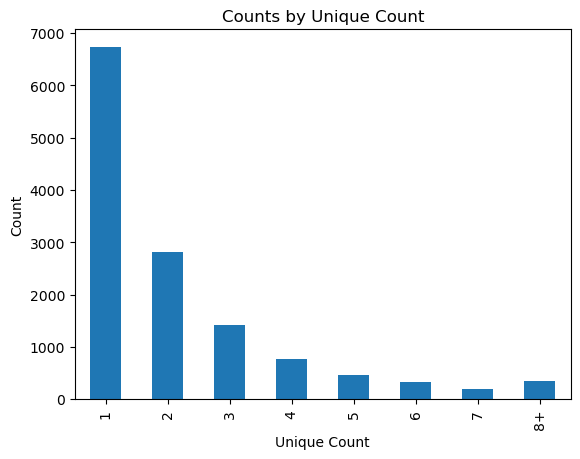

COUNT
1     6731
2     2806
3     1421
4      776
5      452
6      322
7      195
8+     344
dtype: int64


In [258]:
# total_counts df의 count column으로 plot 찍어보기
# count 칼럼을 기준으로 그룹을 지어서 그룹마다의 개수를 구함
count_by_count = total_counts.groupby('COUNT').size()

# Count가 7번 이상인 경우 '8+'로 표시하여 카운트를 합침
count_by_count = count_by_count.groupby(count_by_count.index.where(count_by_count > 190, '8+')).sum()

# bar 그래프 그리기
count_by_count.plot(kind='bar')

# 그래프 꾸미기
plt.title('Counts by Unique Count')
plt.xlabel('Unique Count')
plt.ylabel('Count')

# 그래프 출력
plt.show()

print(count_by_count)

##### 1-3. 전체 time-series mean plot

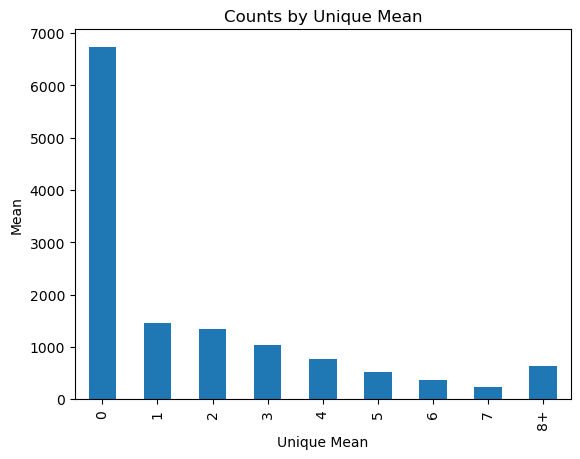

MEAN
0     6731
1     1455
2     1335
3     1030
4      759
5      511
6      372
7      223
8+     631
dtype: int64


In [259]:
# total_counts df의 mean column으로 plot 찍어보기

# count 칼럼을 기준으로 그룹을 지어서 그룹마다의 개수를 구함
count_by_mean = total_counts.groupby('MEAN').size()

# MEAN이 7일 이상인 경우 '8+'로 표시하여 카운트를 합침
count_by_mean = count_by_mean.groupby(count_by_mean.index.where(count_by_mean > 200, '8+')).sum()

# bar 그래프 그리기
count_by_mean.plot(kind='bar')

# 그래프 꾸미기
plt.title('Counts by Unique Mean')
plt.xlabel('Unique Mean')
plt.ylabel('Mean')

# 그래프 출력
plt.show()

print(count_by_mean)

##### 1-4.Respiratory 환자의 time-series count plot(7,631->4,885명)

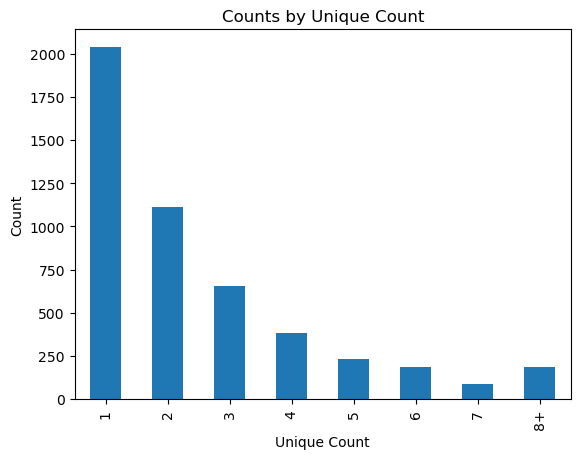

COUNT
1     2038
2     1115
3      656
4      385
5      234
6      185
7       89
8+     183
dtype: int64


In [260]:
# Respiratory 환자의 경우 유효성 검사
df = pd.read_csv("~/project/MIMIC-III/Data/SUBJECTID.csv")
merged_df = pd.merge(total_counts, df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# count 칼럼을 기준으로 그룹을 지어서 그룹마다의 개수를 구함
count_by_count = merged_df.groupby('COUNT').size()

# Count가 7번 이상인 경우 '8+'로 표시하여 카운트를 합침
count_by_count = count_by_count.groupby(count_by_count.index.where(count_by_count > 80, '8+')).sum()

# bar 그래프 그리기
count_by_count.plot(kind='bar')

# 그래프 꾸미기
plt.title('Counts by Unique Count')
plt.xlabel('Unique Count')
plt.ylabel('Count')

# 그래프 출력
plt.show()

print(count_by_count)

##### 1-5.Respiratory 환자의 time-series mean plot(7,631->4,885명)

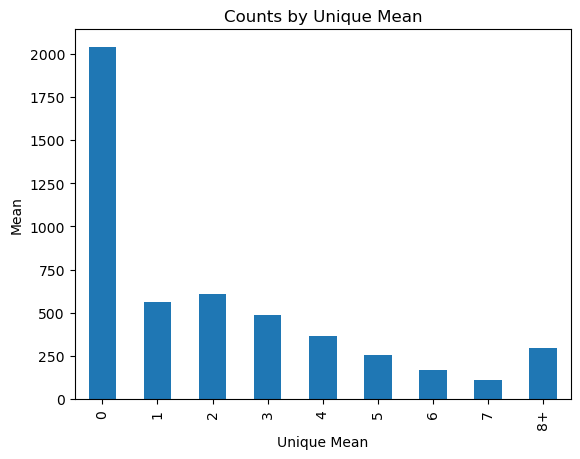

MEAN
0     2038
1      561
2      607
3      487
4      364
5      256
6      167
7      110
8+     295
dtype: int64


In [261]:
# count 칼럼을 기준으로 그룹을 지어서 그룹마다의 개수를 구함
count_by_mean = merged_df.groupby('MEAN').size()

# MEAN이 7일 이상인 경우 '8+'로 표시하여 카운트를 합침
count_by_mean = count_by_mean.groupby(count_by_mean.index.where(count_by_mean > 100, '8+')).sum()

# bar 그래프 그리기
count_by_mean.plot(kind='bar')

# 그래프 꾸미기
plt.title('Counts by Unique Mean')
plt.xlabel('Unique Mean')
plt.ylabel('Mean')

# 그래프 출력
plt.show()

print(count_by_mean)

#### 2. ID에 따라 결측치 여부 확인(Respiratory 환자 4,885명)

In [243]:
# Respiratory 환자의 Laboratory value만 추출
df1 = pd.read_csv("~/project/MIMIC-III/Data/ITEMLIST.csv")
df2 = pd.read_csv("~/project/MIMIC-III/Data/SUBJECTID.csv")
df = pd.merge(df1, df2, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
df.sort_values(["SUBJECT_ID","HADM_ID", "CHARTDATE"], inplace = True)
df

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
3,159,36,165660,2134-05-12 00:00:00,2134-05-12 17:19:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,649,91,121205,2177-05-08 00:00:00,2177-05-08 13:40:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,675,94,140037,2176-09-03 00:00:00,2176-09-03 10:18:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,676,94,140037,2176-09-05 00:00:00,2176-09-05 10:16:00,70062.0,SPUTUM,80075.0,YEAST,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,682,94,140037,2176-09-07 00:00:00,2176-09-07 17:15:00,70062.0,SPUTUM,80075.0,YEAST,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42767,631673,99985,176670,2181-01-29 00:00:00,2181-01-29 10:07:00,70062.0,SPUTUM,80023.0,STAPH AUREUS COAG +,1.0,90008.0,TRIMETHOPRIM/SULFA,<=0.5,<=,1.0,S
42768,631674,99985,176670,2181-01-29 00:00:00,2181-01-29 10:07:00,70062.0,SPUTUM,80023.0,STAPH AUREUS COAG +,1.0,90012.0,GENTAMICIN,<=0.5,<=,1.0,S
42769,631682,99985,176670,2181-01-30 00:00:00,2181-01-30 23:11:00,70062.0,SPUTUM,80023.0,STAPH AUREUS COAG +,1.0,NaN,NaN,NaN,NaN,NaN,NaN
42770,631687,99985,176670,2181-02-02 00:00:00,2181-02-02 14:37:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
# SUBJECT_ID, HADM_ID, SPEC_ITEMID로 그룹바이 후 다른 칼럼들의 결측치 비율을 구한다.
# 0, 36, 100은 각각 결측치 0%, 36%,100%를 의미한다.
grouped = df.groupby(['SUBJECT_ID', 'HADM_ID', 'SPEC_ITEMID'])
nulls = grouped[['CHARTDATE', 'CHARTTIME','SPEC_TYPE_DESC', 'ORG_ITEMID', 'ORG_NAME','ISOLATE_NUM', 
                 'AB_ITEMID', 'AB_NAME', 'DILUTION_TEXT','DILUTION_COMPARISON', 'DILUTION_VALUE', 'INTERPRETATION']].apply(lambda x: x.isnull().mean()*100)

nulls[['CHARTDATE', 'CHARTTIME','SPEC_TYPE_DESC', 'ORG_ITEMID', 'ORG_NAME','ISOLATE_NUM','AB_ITEMID',
       'AB_NAME', 'DILUTION_TEXT','DILUTION_COMPARISON', 'DILUTION_VALUE', 'INTERPRETATION']] = nulls[['CHARTDATE', 
        'CHARTTIME','SPEC_TYPE_DESC', 'ORG_ITEMID', 'ORG_NAME','ISOLATE_NUM', 'AB_ITEMID', 
        'AB_NAME', 'DILUTION_TEXT','DILUTION_COMPARISON', 'DILUTION_VALUE', 'INTERPRETATION']].astype(int)
nulls

,,,CHARTDATE,CHARTTIME,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
SUBJECT_ID,HADM_ID,SPEC_ITEMID,,,,,,,,,,,,
36,165660,70062.0,0,0,0,100,100,100,100,100,100,100,100,100
91,121205,70062.0,0,0,0,100,100,100,100,100,100,100,100,100
94,140037,70062.0,0,0,0,50,50,50,100,100,100,100,100,100
101,175533,70062.0,0,33,0,100,100,100,100,100,100,100,100,100
111,192123,70062.0,0,0,0,0,0,0,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99847,155024,70062.0,0,0,0,36,36,36,100,100,100,100,100,100
99863,100749,70062.0,0,0,0,66,33,33,100,100,100,100,100,100
99899,188409,70062.0,0,0,0,0,0,0,100,100,100,100,100,100


##### 2-1. CHARTDATE 결측치 Plot

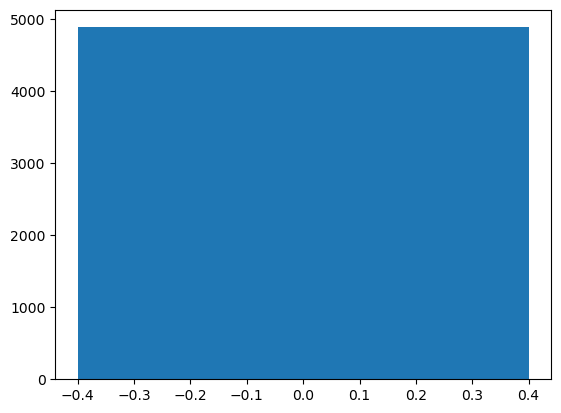

In [244]:
value_counts = nulls['CHARTDATE'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-2. CHARTTIME 결측치 Plot

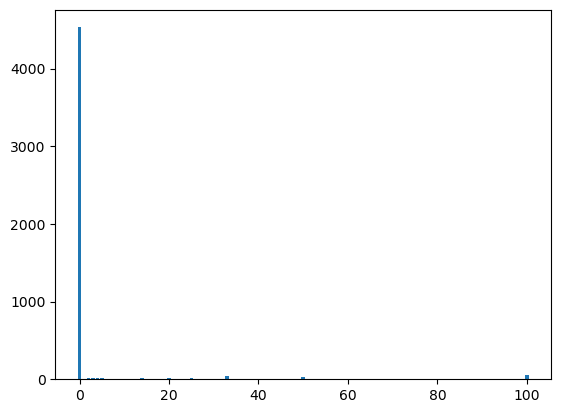

In [245]:
value_counts = nulls['CHARTTIME'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-3. SPEC_TYPE_DESC

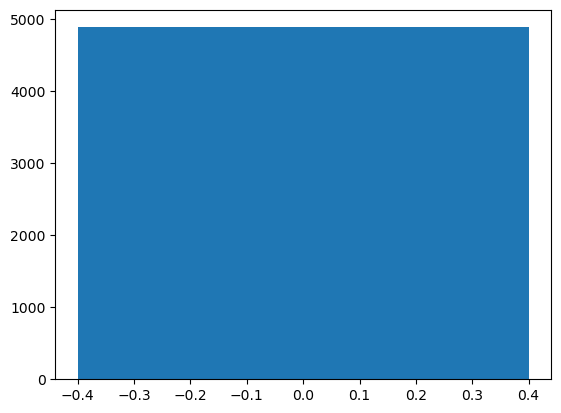

In [229]:
value_counts = nulls['SPEC_TYPE_DESC'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-4. ORG_ITEMID

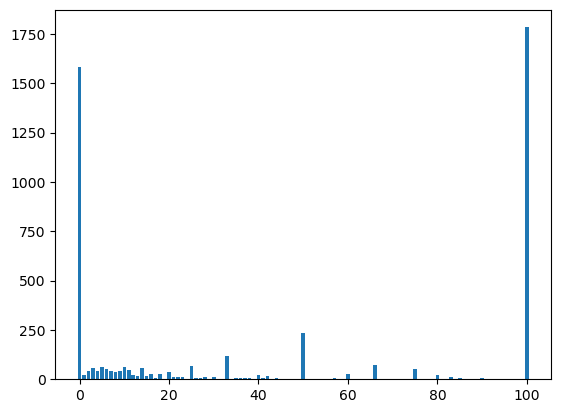

In [230]:
value_counts = nulls['ORG_ITEMID'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-5. ISOLATE_NUM	

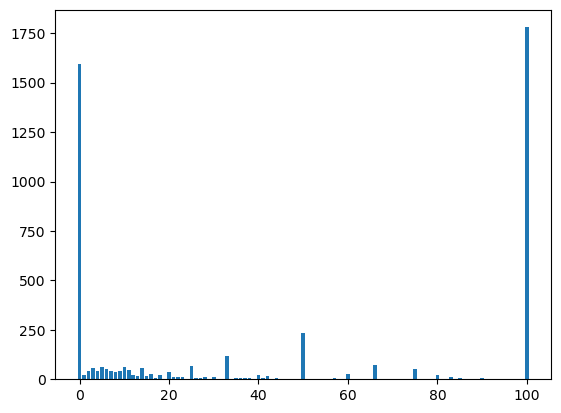

In [231]:
value_counts = nulls['ISOLATE_NUM'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-6. AB_ITEMID	

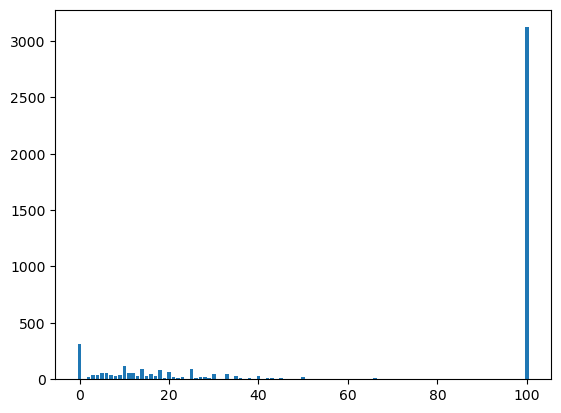

In [232]:
value_counts = nulls['AB_ITEMID'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-7. AB_NAME

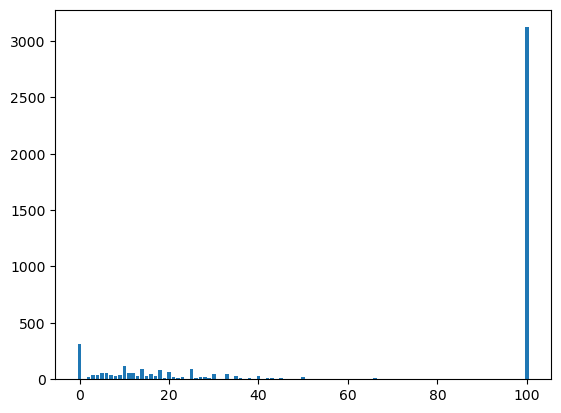

In [233]:
value_counts = nulls['AB_NAME'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-8. DILUTION_TEXT

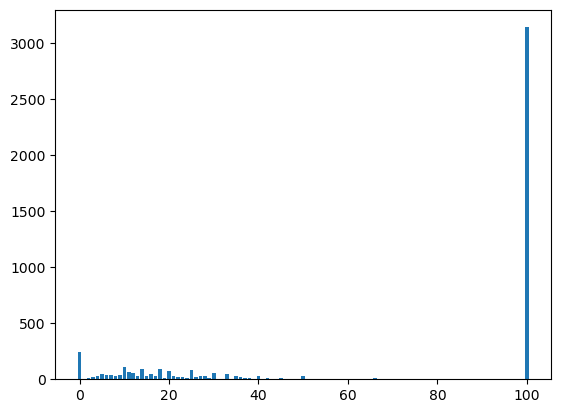

In [234]:
value_counts = nulls['DILUTION_TEXT'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-9. DILUTION_COMPARISON

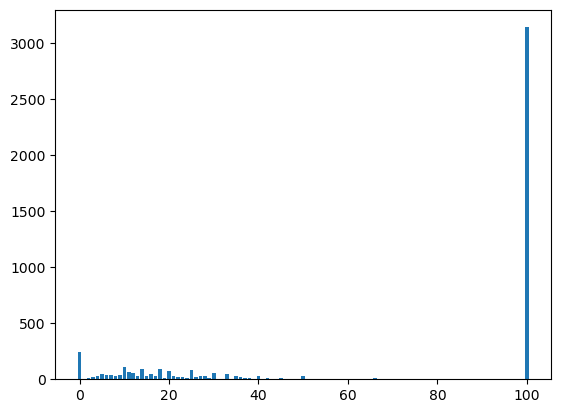

In [235]:
value_counts = nulls['DILUTION_COMPARISON'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-10. DILUTION_VALUE	

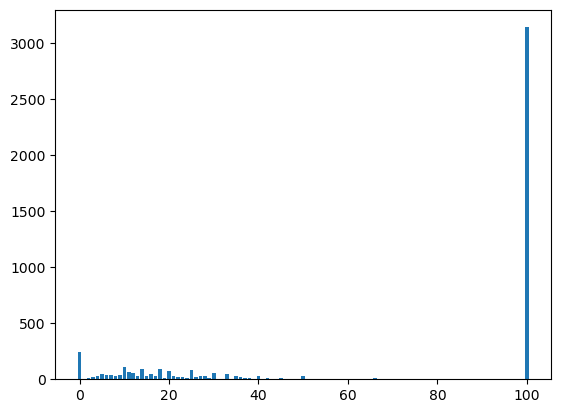

In [236]:
value_counts = nulls['DILUTION_VALUE'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-11. INTERPRETATION

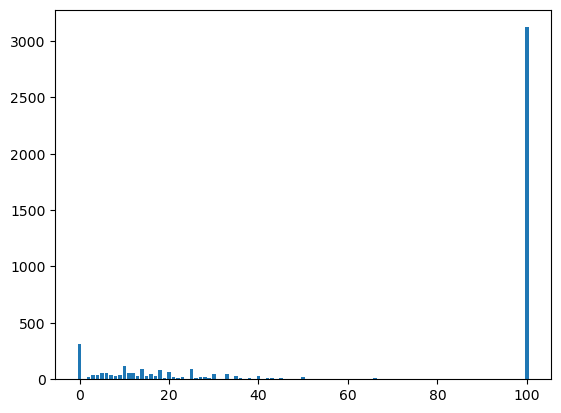

In [237]:
value_counts = nulls['INTERPRETATION'].value_counts()

# 빈도 분포를 시각화
plt.bar(value_counts.index, value_counts.values)
plt.show()

##### 2-12. 전체 column의 결측치 분포

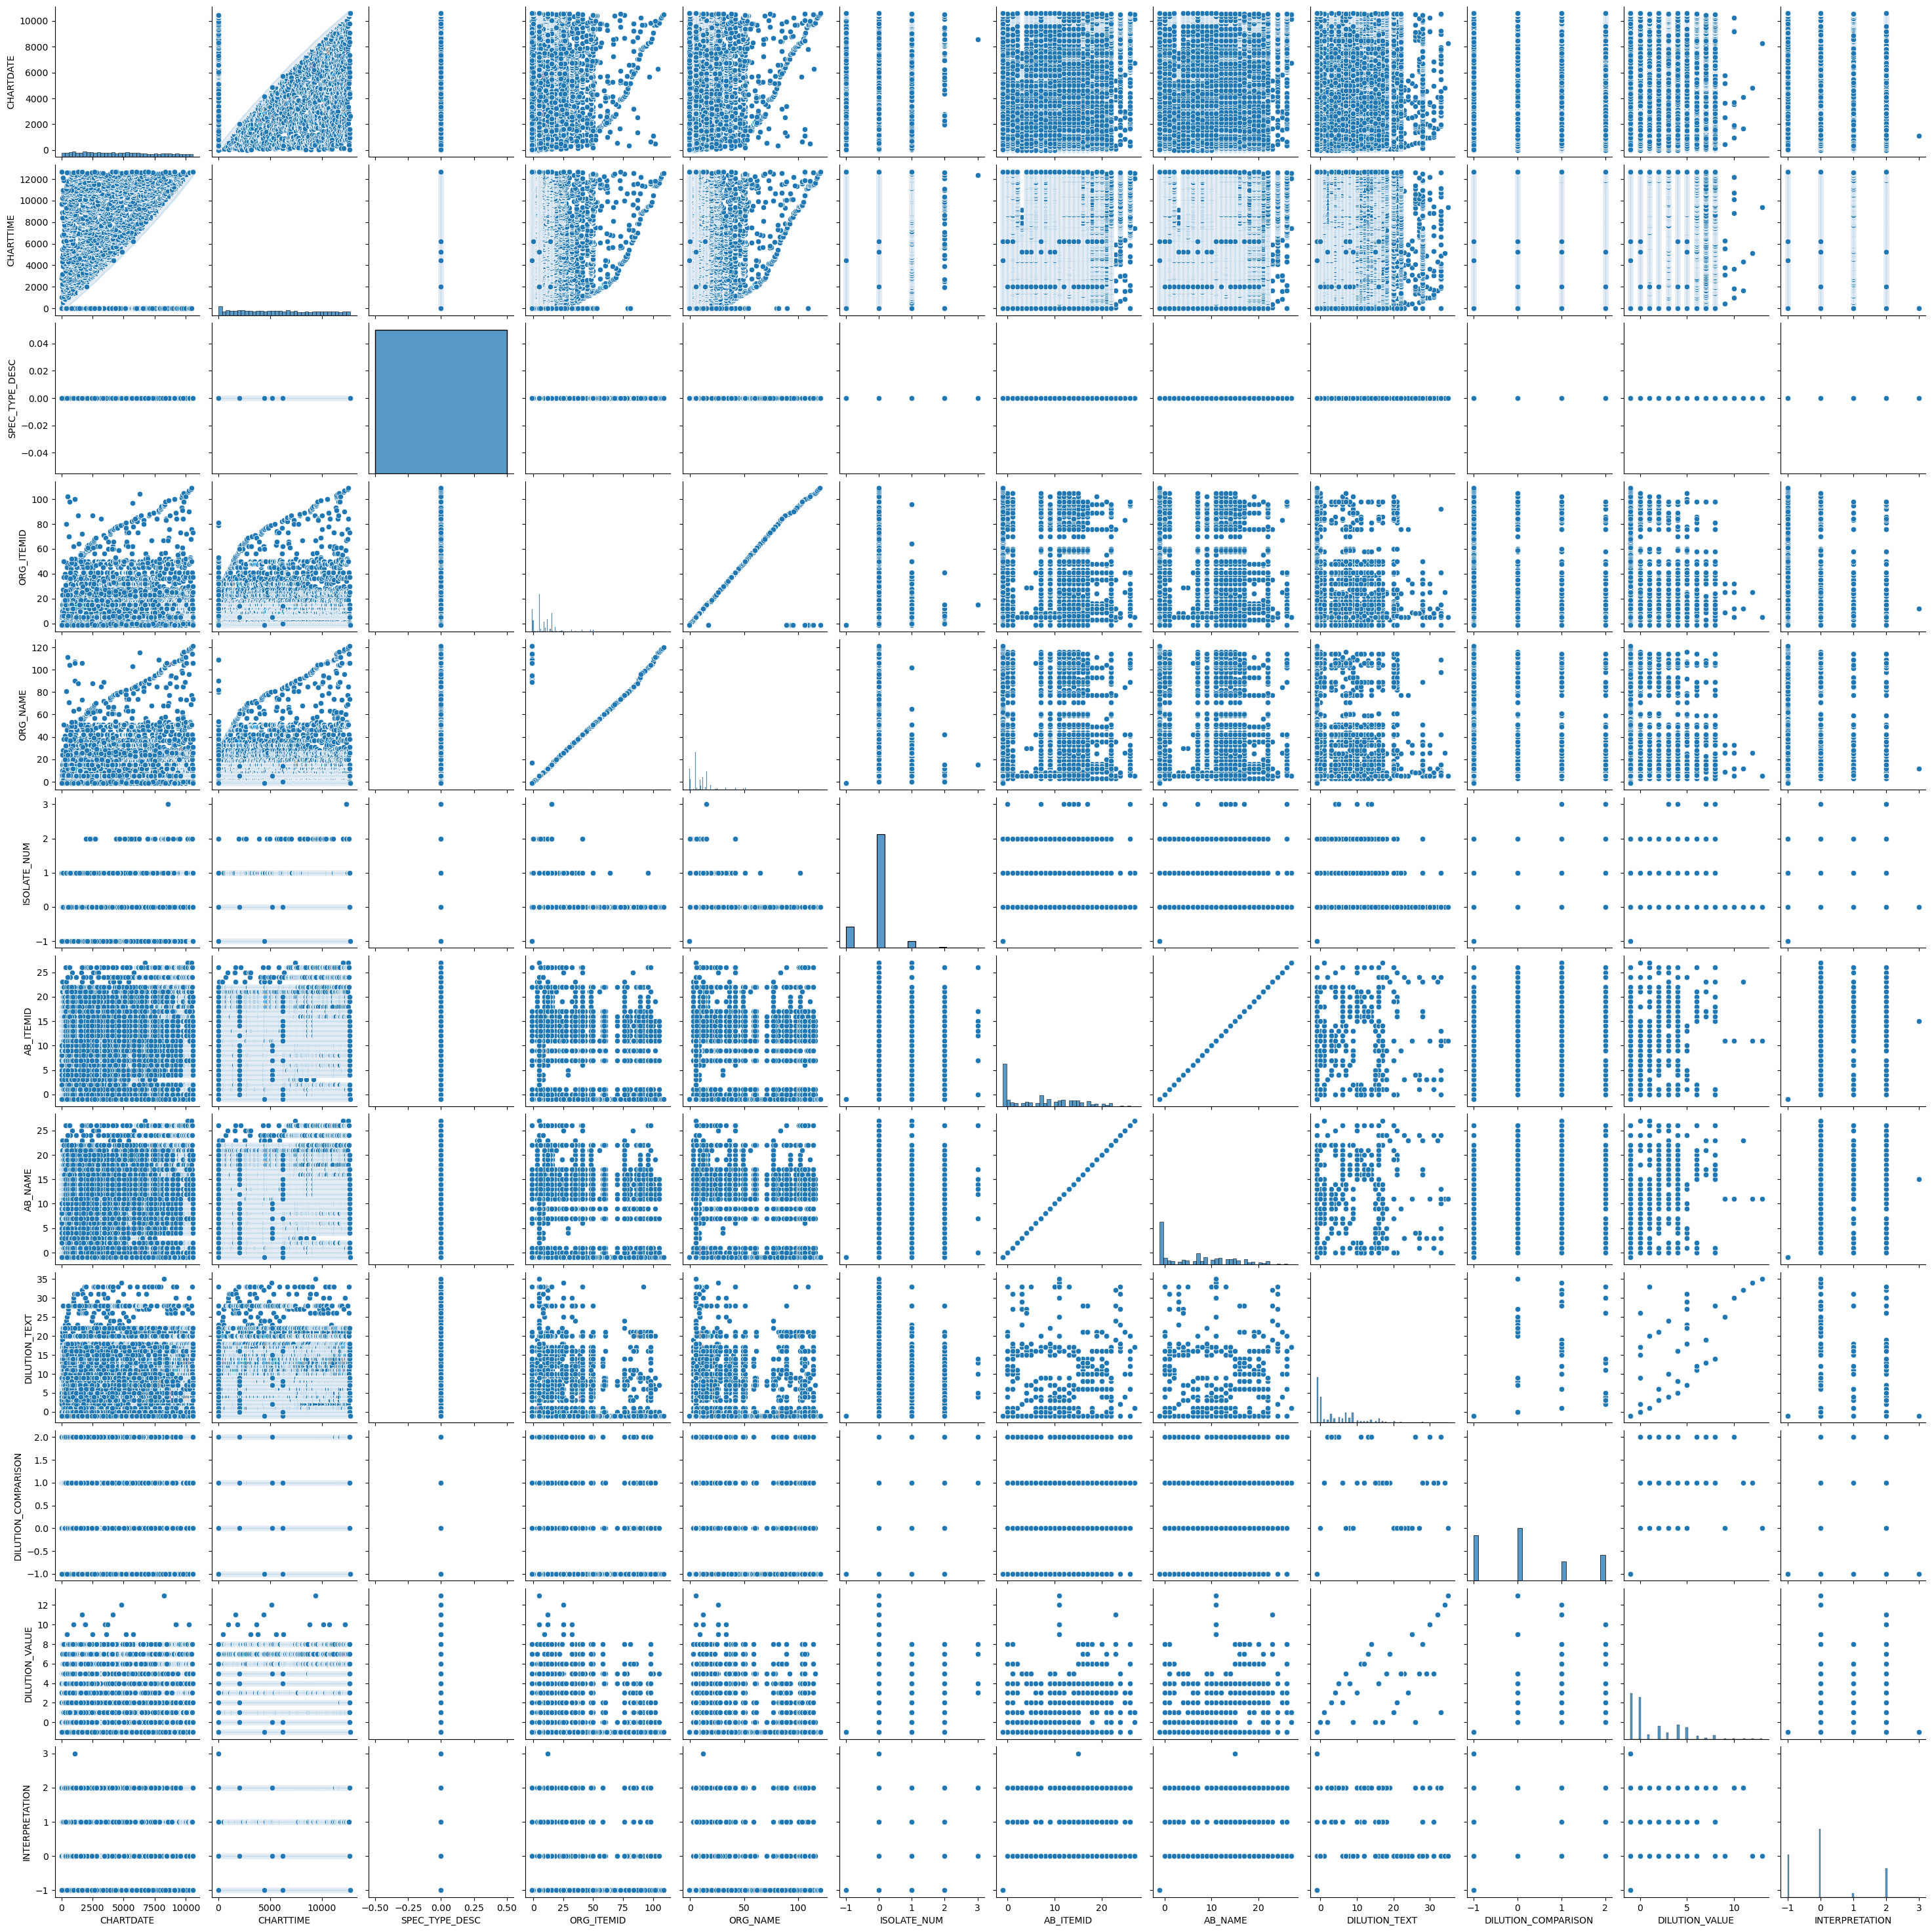

In [193]:
# 전체 column의 unique 값 분포
sns.pairplot(df[['CHARTDATE', 'CHARTTIME','SPEC_TYPE_DESC', 'ORG_ITEMID', 'ORG_NAME','ISOLATE_NUM','AB_ITEMID',
       'AB_NAME', 'DILUTION_TEXT','DILUTION_COMPARISON', 'DILUTION_VALUE', 'INTERPRETATION']].apply(lambda x: pd.factorize(x)[0]))

#### 3. Dense한 ITEMID 조사

In [252]:
nulls = nulls.reset_index()
nulls

,index,SUBJECT_ID,HADM_ID,SPEC_ITEMID,CHARTDATE,CHARTTIME,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
0,0,36,165660,70062.0,0,0,0,100,100,100,100,100,100,100,100,100
1,1,91,121205,70062.0,0,0,0,100,100,100,100,100,100,100,100,100
2,2,94,140037,70062.0,0,0,0,50,50,50,100,100,100,100,100,100
3,3,101,175533,70062.0,0,33,0,100,100,100,100,100,100,100,100,100
4,4,111,192123,70062.0,0,0,0,0,0,0,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4880,4880,99847,155024,70062.0,0,0,0,36,36,36,100,100,100,100,100,100
4881,4881,99863,100749,70062.0,0,0,0,66,33,33,100,100,100,100,100,100
4882,4882,99899,188409,70062.0,0,0,0,0,0,0,100,100,100,100,100,100
4883,4883,99912,189380,70062.0,0,0,0,0,0,0,10,10,10,10,10,10


In [253]:
dense_id = nulls['SPEC_ITEMID'].value_counts().idxmax()
print(dense_id)

70062.0
